In [1]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')
%matplotlib widget

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy   as     gp
import matplotlib.patches as mpatches
from   gurobipy   import GRB
from globalFunctions import getNumberOfBlocksInADimension
from openPitFunctions import finalBlock
from globalFunctions import getNumberOfBlocksInADimension
from drawpointFunction  import drawpointFunction
from itertools import chain
from functools import reduce
from plotDrawpointsPoints import plotDrawpointsPoints
from plotGurobiOpenPitSolution import plotGurobiOpenPitSolution
from plotIntegratedOmpSolution import plotIntegratedOmpSolution
from plotOmpOpenPitSolution import plotOmpOpenPitSolution
from plotUndergroundSolution import plotUndergroundSolution

In [3]:
#path = "C:/Users/willi/OneDrive/Escritorio/Magister/Tesis-Magister/Database/undergroundModel/" #Notebook
path = "/home/williams/Tesis-Magister/Databases/"
#path = "C:/Users/Williams Medina/Desktop/Tesis Magister/Tesis-Magister/ThesisCode/MainCode/Databases/undergroundModel/" #Desktop
undergroundDatabaseName = 'Modelo_F_OG.xlsx'
#openPitDatabaseName = 'Modelo_F_OG.xlsx'
openPitDatabaseName = 'modelo_reblogeado.xlsx'

In [4]:
if undergroundDatabaseName == openPitDatabaseName:
    undergroundMineDataframe = pd.read_excel(path + undergroundDatabaseName, engine="openpyxl") #Notebook
    openPitDataframe = undergroundMineDataframe
else:
    undergroundMineDataframe = pd.read_excel(path + undergroundDatabaseName, engine="openpyxl") #Notebook
    openPitDataframe = pd.read_excel(path + openPitDatabaseName, engine="openpyxl") #Notebook

In [20]:
class IntegratedModel:
    def __init__(self, undergroundMineDataframe, openMineDataframe, numberOfPeriods):
        self.openMineDataframe = openMineDataframe
        self.undergroundMineDataframe = undergroundMineDataframe
        self.numberOfPeriods = numberOfPeriods
        self.safetyLevel = 60
        self.colHeight = 790#630#self.undergroundBlocksHeightLimits[1] - self.undergroundBlocksHeightLimits[2]
        self.minColHeight = 0.40
        self.pos_x = 440#440#Coordenada x desde donde empezamos a extraer     
        self.pos_y = 550#550#Coordenada y desde donde empezamos a extraer
        self.pos_z = 530#780#Coordenada z desde donde empezamos a extraer     
        self.pos_x_f = 720#720#Coordenada x hazta donde extrameos  
        self.pos_y_f = 910#910#Coordenada y hazta donde extrameos
        self.p_t = 3791.912 
        self.desc = 0.1
        self.DP_init = 0       #### Tipo de extracción
        self.orientationToExtractTheDrawpoints = 0


    def execute(self):
        self.setOpenPitVariables()
        self.setUndergroundVariables()
        self.setMineLimits()
        self.getBlockInfo()
        self.setParametersToEvaluate()
        self.setGlobalParameters()
        self.getUndergroundVariables()
        self.setPossibleHeights()
        self.setModelAndGetResults()  
        return self.objValue, self.variableValues, self.runtime, self.gap , self.x_dt_values, self.y_dt_values, self.z_dt_values, self.x_bt_values

    def setOpenPitVariables(self):
        self.openPitBlocksLength = self.openMineDataframe['X'].to_dict() 
        self.openPitBlocksWidth = self.openMineDataframe['Y'].to_dict() 
        self.openPitBlocksHeight = self.openMineDataframe['Z'].to_dict() 
        self.L_b = self.openMineDataframe['Ton'].to_dict() #openPitBlockTonnage
        self.o_b = self.openMineDataframe['Mineral'].to_dict() #openPitBlockMineral
        self.openPitBlockRecovery = self.openMineDataframe['Recuperación'].to_dict() #openPitBlockRecovery
        self.openPitCopperLaw = self.openMineDataframe['%Cu'].to_dict() #openPitCopperLaw
        self.c_pbt = self.openMineDataframe['CPlanta CA'].to_dict() #openPitPlantCapacity
        self.c_mbt = self.openMineDataframe['CMina CA'].to_dict() #openPitMineCapacity
      
    def setUndergroundVariables(self):
        self.undergroundBlocksLength = self.undergroundMineDataframe['X'].to_dict()             
        self.undergroundBlocksWidth  = self.undergroundMineDataframe['Y'].to_dict()             
        self.undergroundBlocksHeight = self.undergroundMineDataframe['Z'].to_dict()             
        self.undergroundBlockTonnage = self.undergroundMineDataframe['Ton'].to_dict()              
        self.undergroundBlockMineral  = self.undergroundMineDataframe['Mineral'].to_dict()          
        self.undergroundBlockRecovery  = self.undergroundMineDataframe['Recuperación'].to_dict()     
        self.undergroundCopperLaw  = self.undergroundMineDataframe['%Cu'].to_dict()
        self.undergroundExtractionFixedCosts = self.undergroundMineDataframe['CPlanta CA'].to_dict()
        self.undergroundVariableExtractionCosts = self.undergroundMineDataframe['CMina CA'].to_dict()
        self.undergroundCP_S = self.undergroundMineDataframe['CPlanta S'].to_dict()
        self.undergroundCM_S = self.undergroundMineDataframe['CMINA S'].to_dict() 

    def setMineLimits(self):
        self.undergroundBlocksLenghtLimits = getNumberOfBlocksInADimension(self.undergroundBlocksLength)
        self.undergroundBlocksWidthLimits = getNumberOfBlocksInADimension(self.undergroundBlocksWidth)
        self.undergroundBlocksHeightLimits = getNumberOfBlocksInADimension(self.undergroundBlocksHeight)

        self.openPitBlocksLengthLimits = getNumberOfBlocksInADimension(self.openPitBlocksLength)
        self.openPitBlocksWidthLimits = getNumberOfBlocksInADimension(self.openPitBlocksWidth)
        self.openPitBlocksHeightLimits = getNumberOfBlocksInADimension(self.openPitBlocksHeight)

    def getBlockInfo(self):
        self.openPitBlocks = [i for i in range(len(self.openPitBlocksLength.values()))]
        self.S_blocks = [i for i in range(len(self.undergroundBlocksLength.values()))]

    def setParametersToEvaluate(self):
        #OpenPit Parameters
        self.t_C   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.RMu_t = {period : 2 * 25806600.0/1 for period in range(self.numberOfPeriods)}#Superior infinita, 0 por abajo Originales: 13219200
        self.RMl_t = {period : 0.0/3 for period in range(self.numberOfPeriods)}#Valor original 8812800.0
        self.RPu_t = {period : 2 * 17777880.0/1 for period in range(self.numberOfPeriods)}#Valor original 10933380.0
        self.RPl_t = {period : 0/3 for period in range(self.numberOfPeriods)}#Valor original 7288920.0 
        self.qu_t  = {period : 1 for period in range(self.numberOfPeriods)}#Leyes promedio maxima y minima.
        self.ql_t  = {period : 0.0001 for period in range(self.numberOfPeriods)}
        
        #Underground Parameters
        self.t_S   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.MU_mt = {period : 25806600.0/1  for period in range(self.numberOfPeriods)} #Tonleage es mina
        self.ML_mt = {period : 0/3  for period in range(self.numberOfPeriods)}
        self.MU_pt = {period : 17777880.0/1  for period in range(self.numberOfPeriods)}#Mineral es planta
        self.ML_pt = {period : 0/3 for period in range(self.numberOfPeriods)}
        self.qU_dt = {period : 1 for period in range(self.numberOfPeriods)}
        self.qL_dt = {period : 0.0001 for period in range(self.numberOfPeriods)}
        self.A_d   = {period : 2 for period in range(self.numberOfPeriods)}
        self.NU_nt = {period : 59 for period in range(self.numberOfPeriods)} 
        self.NL_nt = {period : 0 for period in range(self.numberOfPeriods)}
        self.N_t   = {period : 59* (1 + period) for period in range(self.numberOfPeriods)}
        self.RL_dt = {period : 0.2 for period in range(self.numberOfPeriods)}
        self.RU_dt = {period : 1 for period in range(self.numberOfPeriods)}
            
        self.maxTimeOpenPit = self.t_C[max(self.t_C)]
        self.maxTimeUnderground = self.t_S[max(self.t_S)]

    def setGlobalParameters(self):
        self.setMineLimits()
        self.predecessorBlock = self.setPredecessorBlock()
        self.predecessorsBlocks = {}
        
        for blocklist in self.predecessorBlock:
            if blocklist[0] not in self.predecessorsBlocks.keys():
                self.predecessorsBlocks[blocklist[0]] = []
            if blocklist[0] != blocklist[1]:
                self.predecessorsBlocks[blocklist[0]].append(blocklist[1])

        self.dif_centroide = self.openPitBlocksLengthLimits[0]//2 - self.undergroundBlocksLenghtLimits[0]//2


    def setPredecessorBlock(self):
        predecessorBlock = []
        superiorBlock = finalBlock(self.openPitBlocks, self.openPitBlocksLengthLimits,self.openPitBlocksWidthLimits, self.openPitBlocksHeightLimits)
        for i in range(len(self.openPitBlocks)):
            for j in superiorBlock[i]:
                aux_1 = []
                aux_1.append(self.openPitBlocks[i])
                aux_1.append(j)
                predecessorBlock.append(aux_1)
        
        return predecessorBlock

    def getUndergroundVariables(self):
        
  
        
        self.drawpoint, self.G_d, self.Q_d,self.q_d, self.C_pdt, self.C_mdt, self.predecessor, self.x_draw,self.y_draw, self.z_draw, self.drawpoints_blocks = drawpointFunction(
                        self.pos_x, self.pos_y, self.pos_z, self.colHeight, self.DP_init, self.undergroundBlocksLenghtLimits, self.undergroundBlocksWidthLimits, self.undergroundBlocksHeightLimits, self.undergroundBlockTonnage, self.undergroundCP_S, self.undergroundCM_S, self.undergroundBlockMineral,
                        self.undergroundCopperLaw, self.pos_x_f, self.pos_y_f,self.orientationToExtractTheDrawpoints)
        """
        self.drawpointsPredecessorDict = {}
        self.drawpointsPredecessorDict[0] = []
        self.drawpointsPredecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            self.drawpointsPredecessorDict[self.predecessor[i][0]] =  [*reduce(lambda x, y: set(x) | set(y), self.predecessor[:i])]
        """ 
        self.drawpointsPredecessorDict = {}
        self.drawpointsPredecessorDict[0] = []
        self.drawpointsPredecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            if self.predecessor[i][0] not in self.drawpointsPredecessorDict.keys():
                self.drawpointsPredecessorDict[self.predecessor[i][0]] = []
            self.drawpointsPredecessorDict[self.predecessor[i][0]].append(self.predecessor[i][1])
         
           
    def setPossibleHeights(self):
        self.blockHeight, self.maxHeight, self.minHeight, self.numOfDifferentsBlocks = self.openPitBlocksHeightLimits

    def setModelAndGetResults(self):
        self.objValue, self.variableValues, self.runtime, self.gap = self.setIntegratedModel()

    def setIntegratedModel(self):
         
        self.integratedModel = gp.Model(name = 'Modelo Integrado')
        
        # Open Pit tengo la variable del modelo cielo abierto continua
        self.x_bt = self.integratedModel.addVars(self.t_C, self.openPitBlocks, vtype=GRB.BINARY, name="x_b")
        
        #1. Restricci ́on sobre la cantidad de tonelaje m ́axima y m ́ınima a extraer en cada periodo.
        openPitModel_Ton_Up  = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) 
                                <= self.RMu_t[ti] for ti in self.t_C), "Ton_max")
        openPitModel_Ton_low = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) 
                                >= self.RMl_t[ti] for ti in self.t_C), "Ton_min")

        #2. Restricci ́on sobre la cantidad de material m ́axima y m ́ınima a extraer en cada periodo.
        openPitModel_Mat_Up_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.o_b[b] for b in self.openPitBlocks) <= 
                                self.RPu_t[ti] for ti in self.t_C), "Mat_max")
        openPitModel_Mat_low_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.o_b[b] for b in self.openPitBlocks) >= 
                                self.RPl_t[ti] for ti in self.t_C), "Mat_min")

        #3. Restricci ́on de precedencia de los bloques a extraer, debemos extraer los 5 bloques superiores al bloque objetivo para sacar a este
        
        #BLOCK_SUP_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[s, self.predecessorBlock[l][0]]*(self.maxTimeOpenPit-s+1) for s in self.t_C) <= 
        #                              gp.quicksum(self.x_bt[s, self.predecessorBlock[l][1]]*(self.maxTimeOpenPit-s+1) for s in self.t_C)  
        #                           for l in range(len(self.predecessorBlock))), "Superior_Block")
        openPitModel_Precedence = self.integratedModel.addConstrs(gp.quicksum(self.x_bt[s,a] for s in range(0,ti+1)) >= self.x_bt[ti, b] for b in self.openPitBlocks for ti in self.t_C for a in self.predecessorsBlocks[b])


        #4. Restricci ́on sobre la ley m ́axima y m ́ınima por periodo.
        openPitModel_GQC_Up_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b]*self.openPitCopperLaw[b] for b in self.openPitBlocks) <=
                            self.qu_t[ti] * gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) for ti in self.t_C), 
                                "openPitModel_GQC_Up")

        openPitModel_GQC_low_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b]*self.openPitCopperLaw[b] for b in self.openPitBlocks) >=
                            self.ql_t[ti] * gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) for ti in self.t_C), 
                                "openPitModel_GQC_LOW")

        #5. Podemos extraer el bloque en un solo periodo.
        openPitModel_Reserve_cons_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b] for ti in self.t_C) <= 1 for b in self.openPitBlocks), 
                                "openPitModel_Reserve_cons")

        #Función objetivo
        self.openPitObjectiveFunction = gp.quicksum(self.x_bt[ti, b]*((((self.p_t*self.openPitCopperLaw[b]-self.c_pbt[b])*self.o_b[b])-(self.c_mbt[b]*self.L_b[b]))/((1+self.desc)**self.t_C[ti]))
                    for ti in self.t_C for b in self.openPitBlocks)
        
        
        # Underground  Model

        #14. Naturaleza de las variables
        self.x_dt = self.integratedModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="x_d")
        self.y_dt = self.integratedModel.addVars(self.drawpoint, self.t_S, vtype=GRB.CONTINUOUS, name="y_d")
        self.z_dt = self.integratedModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="z_d")

        #1. Restricción sobre la cantidad de tonelaje máxima y mínima a extraer en cada periodo.
        Ton_Up = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti]*self.G_d[d] for d in self.drawpoint) <= self.MU_mt[ti] for ti in self.t_S),
                                         "Min_max")
        
        Ton_low = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.G_d[d] for d in self.drawpoint) >= self.ML_mt[ti] for ti in self.t_S),
                                            "Min_min")
        #2. Restricción sobre la cantidad de material máxima y mínima a procesar en cada periodo.
        Mat_Up = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) <= self.MU_pt[ti] for ti in self.t_S),
                                            "Mat_max")

        Mat_low = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) >= self.ML_pt[ti] for ti in self.t_S)
                                            , "Mat_min")

        
        #3. Rango de leyes máximas y mínimas a procesar
        GQC_low = self.integratedModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) >=
                                self.qL_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_low")
        
        GQC_Up = self.integratedModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) <=
                                self.qU_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_Up")

        #4. Todos los puntos de extracción deben ser iniciados en el largo de la extracción
        Drawp_init = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for ti in self.t_S) == 1 for d in self.drawpoint), "Drawp_init")

        #5. Los puntos de extracción deben ser activados al menos en el mismo periodo para que se inicie la extracción 
        Drawpextract_61 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, tau] for tau in range(ti+1)) >= self.z_dt[d, ti]  
                                            for d in self.drawpoint for ti in self.t_S), "Drawpextract_61")


        #6. Existe una cantidad máxima y mínima de drawpoints a abrir en cada periodo.
        Drawpextract_64_1 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.NU_nt[ti] for ti 
                                                        in self.t_S)
                                                        ,"Drawpextract_64_1")
        Drawpextract_64_2 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) >= self.NL_nt[ti] for ti 
                                                        in self.t_S)
                                                        , "Drawpextract_64_2")

        #7. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        Drawpextract_65 = self.integratedModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")


        #8. Si iniciamos la extracción de un drawpoint esta debe durar por su duraci ́on determinada.
        ## Un drawpoint solamente puede ser extraido por un preiodo pre determinado (A_d)
        Drawpextract_62 = self.integratedModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for ti in self.t_S)  <= self.A_d[ti]  for d in self.drawpoint
                                                    for ti in self.t_S), "Drawp_62")

        ## Una vez se inicia extrayendo de un drawpoint, se continua extrayendo sin interrupción
        Drawpextract_63 = self.integratedModel.addConstrs((self.A_d[ti] *(self.z_dt[d, ti] - self.z_dt[d, ti+1]) 
                                            - gp.quicksum(self.z_dt[d, tau] for tau in range(ti+1)) <= 0 
                                            for d in self.drawpoint for ti in range(0,max(self.t_S))), "Drawpextract_63")

        #9. Relación de variables, el porcentaje a extraer es 0 si no se extra un drawpoint.
        Drawpextract_66 = self.integratedModel.addConstrs((self.y_dt[d, ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S),
                                                    "Drawpextract_66")

        #10. Existe una tasa m ́ınima de extracci ́on para cada drawpoint a extraer.
        Drawpextract_67_1 = self.integratedModel.addConstrs((self.RL_dt[ti] * self.z_dt[d, ti]  <=  self.y_dt[d, ti] for d in self.drawpoint
                                                        for ti in self.t_S), "Drawpextract_67_1")

        #11. La altura a extraer debe ser mayor a una cantidad m ́ınima.
        rest_11 = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d,ti] for ti in self.t_S)>= self.minColHeight for d in self.drawpoint))

        #12. No podemos extraer más del 100 % de un drawpoint.
        Reserver_cnst = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] for ti in self.t_S) <= 1 for d in self.drawpoint),
                                                    "Reserver_cnst")

        #13. Si se activa un drawpoint, se extrae en ese periodo
        rest_13 = self.integratedModel.addConstrs(self.x_dt[d,ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S)

        #14. Naturaleza de variables.

        #15. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        rest_15 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")
        
        #16. Restricción sobre el inicio de la extracci ́on de los drawpoints.


        alternative = self.integratedModel.addConstrs(gp.quicksum(self.x_dt[a,s] for s in range(0,ti+1)) >= self.x_dt[d, ti] for d in self.drawpoint for ti in self.t_S for a in self.drawpointsPredecessorDict[d])
        #resta_prec = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[self.predecessor[l][0], m]*(max(self.t_S)-m+1) for m in self.t_S) <=
        #                            gp.quicksum(self.x_dt[self.predecessor[l][1], m]*(max(self.t_S)-m+1) for m in self.t_S)  
        #                            for l in range(len(self.predecessor))), "DP_Sup")

        #Función objetivo
        
        self.undergroundObjectiveFunction = gp.quicksum(self.y_dt[d, ti]*((((self.p_t * self.q_d[d] - self.C_pdt[d] ) * self.Q_d[d])-(self.C_mdt[d]*self.G_d[d]))/
                                        ((1+self.desc)**(self.t_S[ti]))) for ti in self.t_S for d in self.drawpoint)

     
        

        self.V = [height for height in chain(range(self.minHeight,self.maxHeight,self.blockHeight), [self.maxHeight])]
        self.rho_v = {v:( ((v- self.safetyLevel - self.pos_z)/(self.pos_z + self.colHeight  - self.pos_z)) if v - self.pos_z > 0 else 0 ) for v in self.V}
        self.B_v = {}
        for v in self.V:
            numberOfBlocksBelowV = (self.openPitBlocksLengthLimits[3]*self.openPitBlocksWidthLimits[3])*((v-self.minHeight)/self.openPitBlocksHeightLimits[0])
            blocksBelowV = [block for block in range(int(numberOfBlocksBelowV)) if numberOfBlocksBelowV != 0]
            self.B_v[v] = blocksBelowV
        #self.B_v = sorted(self.B_v)
        """
        for v in self.V:
            heightWithSafetyLevel = v + self.safetyLevel
            if heightWithSafetyLevel not in self.B_v.keys():
                closestHeight = next((height for height in sorted(self.V) if height >= heightWithSafetyLevel), None)
                if closestHeight == None:
                    self.B_v[v + self.safetyLevel] = [block for block in range(len(self.openPitBlocks))]
                else:
                    self.B_v[v + self.safetyLevel] = [block for block in range(len(self.B_v[closestHeight]))]
        """
        #Restricciones del crown pillar

        #Variable 1 si y solo si el crown pillar esta ubicado en la elevaci ́on v, 0 en otro caso.
        self.w_v = self.integratedModel.addVars(self.V, vtype=GRB.BINARY, name="w")
        self.u_t = self.integratedModel.addVars(self.t_S, vtype=GRB.BINARY, name="u")
        
        
        test_w = {530: 1.0,
                570: 0.0,
                610: 0.0,
                650: 0.0,
                690: 0.0,
                730: 0.0,
                770: 0.0,
                810: 0.0,
                850: 0.0,
                890: 0.0,
                930: 0.0,
                970: 0.0,
                1010: 0.0,
                1050: 0.0,
                1090: 0.0,
                1130: 0.0,
                1170: 0.0,
                1210: 0.0,
                1250: 0.0,
                1290: 0.0}
        test_u = {0: 0.0,
            1: 0.0,
            2: 0.0,
            3: 0.0,
            4: 0.0,
            5: 0.0}
        #self.u_t = self.integratedModel.addVars(self.t_S,lb=test_u, ub=test_u ,vtype=GRB.BINARY, name="u")
        

        #self.w_v = self.integratedModel.addVars(self.V,lb=test_w, ub=test_w ,vtype=GRB.BINARY, name="w")

        ##Código experimental
        #natu = self.undergroundModel.addConstr(gp.quicksum(self.u_t[t] for t in self.t_S) <= 4)
        time_rest = self.integratedModel.addConstrs(self.u_t[t-1]<= self.u_t[t] for t in range(1, len(self.t_S)))
        
        limit_time = self.integratedModel.addConstrs(self.x_dt[d,t] <= self.u_t[t] for d in self.drawpoint for t in self.t_S)
        
        openpitTrans = self.integratedModel.addConstrs(gp.quicksum(self.x_bt[ti, b] for b in self.openPitBlocks) <= (len(self.openPitBlocks) * (1 - self.u_t[ti])) for ti in self.t_C)
        #self.w_v[745].lb = 1 con esta restricción podemos sacar resultados en función de las iteraciones de las alturas, ej: partir con w_v en diferentes alturas

        #Restricciones del crown pillar if v + self.safetyLevel < max(self.self.B_v.keys())

        
        pillar_1 = self.integratedModel.addConstrs(gp.quicksum(self.x_bt[ti, b] for ti in self.t_C) <= 1 - self.w_v[v] for v in (self.V) for b in self.B_v[v] )


        pillar_2 = self.integratedModel.addConstrs(gp.quicksum(self.y_dt[d, ti] 
                                                        for ti in self.t_S) <= self.rho_v[v] * self.w_v[v] + (1 - self.w_v[v]) for v in self.V for d in self.drawpoint)
       
        pillar_3 = self.integratedModel.addConstr(gp.quicksum(self.w_v[v] for v in self.V) == 1)
        
        #fixed_position = self.integratedModel.addConstrs(self.w_v == w_opt)
        integratedObjectiveFunction = self.undergroundObjectiveFunction + self.openPitObjectiveFunction

        
        self.integratedModel.setObjective(integratedObjectiveFunction, GRB.MAXIMIZE)
        self.integratedModel.Params.MIPGap = 0.05
        #self.integratedModel.Params.TimeLimit = 3600
        
        self.integratedModel.optimize()
        self.x_dt_values = self.integratedModel.getAttr('X', self.x_dt)
        self.y_dt_values = self.integratedModel.getAttr('X', self.y_dt)
        self.z_dt_values = self.integratedModel.getAttr('X', self.z_dt)
        self.x_bt_values = self.integratedModel.getAttr('X', self.x_bt)
        
        # Saca los valores de la solución
        lista_variable_Integrado = self.integratedModel.getAttr(GRB.Attr.X)
        solucion = self.integratedModel.objVal
        runtime = self.integratedModel.Runtime
        gap_f = self.integratedModel.MIPGap
        self.estimatedW_v = {key:value.X for key,value in self.w_v.items()}
        self.estimatedU_t = {key:value.X for key,value in self.u_t.items()}

        return solucion, lista_variable_Integrado, runtime, gap_f

In [21]:
numberOfPeriods = 5

In [22]:
integratedModel = IntegratedModel(undergroundMineDataframe, openPitDataframe, numberOfPeriods)

In [23]:
integratedObjValue, integratedVariableValues, integratedRuntime, integratedGap, x_dt_values, y_dt_values, z_dt_values, x_bt_values = integratedModel.execute()

3391
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 536733 rows, 80945 columns and 2888450 nonzeros
Model fingerprint: 0xa458d13e
Variable types: 840 continuous, 80105 integer (80105 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+06]
  Objective range  [5e+02, 4e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 5e+07]
Presolve removed 95871 rows and 6669 columns (presolve time = 9s) ...
Presolve removed 364111 rows and 46413 columns (presolve time = 10s) ...
Presolve removed 364111 rows and 46413 columns
Presolve time: 10.32s
Presolved: 172622 rows, 34532 columns, 837422 nonzeros
Variable types: 840 continuous, 33692 integer (33692 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolved: 172622 rows, 34532 columns, 83742

GurobiError: Unable to retrieve attribute 'X'

Optimal solution found (tolerance 5.00e-02)
Best objective 2.349344624673e+09, best bound 2.410011175504e+09, gap 2.5823%
985. 0,1...
129 min 30 segs

In [9]:
129*60 + 30

7770

In [14]:
integratedModel.estimatedU_t

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}

In [15]:
integratedModel.estimatedW_v

{530: 0.0,
 570: 0.0,
 610: 0.0,
 650: 0.0,
 690: 0.0,
 730: 0.0,
 770: 0.0,
 810: 0.0,
 850: 0.0,
 890: 0.0,
 930: -0.0,
 970: -0.0,
 1010: -0.0,
 1050: -0.0,
 1090: -0.0,
 1130: -0.0,
 1170: -0.0,
 1210: -0.0,
 1250: -0.0,
 1290: 1.0}

In [12]:
integratedModel.undergroundObjectiveFunction.getValue(), integratedModel.openPitObjectiveFunction.getValue()

(1433039283.8216522, 0.0)

In [13]:
perro

NameError: name 'perro' is not defined

In [ ]:
for i in integratedModel.B_v:
    print(i,len(integratedModel.B_v[i]))

745 0
785 784
825 1568
865 2352
905 3136
945 3920
985 4704
1025 5488
1065 6272
1105 7056
1145 7840
1185 8624
1225 9408
1265 10192
1305 10976


In [ ]:
integratedModel.undergroundObjectiveFunction.getValue(), integratedModel.openPitObjectiveFunction.getValue()



(824686257.4728096, 2215997902.4141307)

In [ ]:
integratedModel.RPu_t

{0: 71111520.0,
 1: 71111520.0,
 2: 71111520.0,
 3: 71111520.0,
 4: 71111520.0,
 5: 71111520.0,
 6: 71111520.0,
 7: 71111520.0,
 8: 71111520.0,
 9: 71111520.0}

In [ ]:
perro

NameError: name 'perro' is not defined

In [ ]:
for v  in integratedModel.B_v:
    print(f'{v} : {len(integratedModel.B_v[v])}')

745 : 0
785 : 784
825 : 1568
865 : 2352
905 : 3136
945 : 3920
985 : 4704
1025 : 5488
1065 : 6272
1105 : 7056
1145 : 7840
1185 : 8624
1225 : 9408
1265 : 10192
1305 : 10976


In [ ]:
len(integratedModel.B_v[1225])

9408

solucion actual 
  1693  1259     cutoff   46      2.2895e+09 2.3922e+09  4.49%  9470 21497s

Cutting planes:
  Gomory: 21
  Lift-and-project: 9
  Cover: 487
  Implied bound: 7870
  MIR: 405
  GUB cover: 62
  Zero half: 161
  RLT: 2694

Explored 1851 nodes (18670473 simplex iterations) in 21497.25 seconds (41234.78 work units)
Thread count was 20 (of 20 available processors)

Solution count 10: 2.28953e+09 2.28953e+09 2.28951e+09 ... 2.28899e+09

Optimal solution found (tolerance 5.00e-02)
Best objective 2.289530408205e+09, best bound 2.392238257565e+09, gap 4.4860%

127 min 8.5 segs
Root relaxation presolved: 127935 rows, 28168 columns, 550957 nonzeros

...
Solution count 10: 2.67711e+09 2.67678e+09 2.67659e+09 ... 2.66917e+09

Optimal solution found (tolerance 5.00e-02)
Best objective 2.677109235681e+09, best bound 2.809224639469e+09, gap 4.9350%

In [ ]:
integratedModel.undergroundBlocksWidthLimits, integratedModel.undergroundBlocksHeightLimits, integratedModel.undergroundBlocksLenghtLimits

((10, 1360, 250, 112), (10, 1320, 530, 80), (10, 1240, 130, 112))

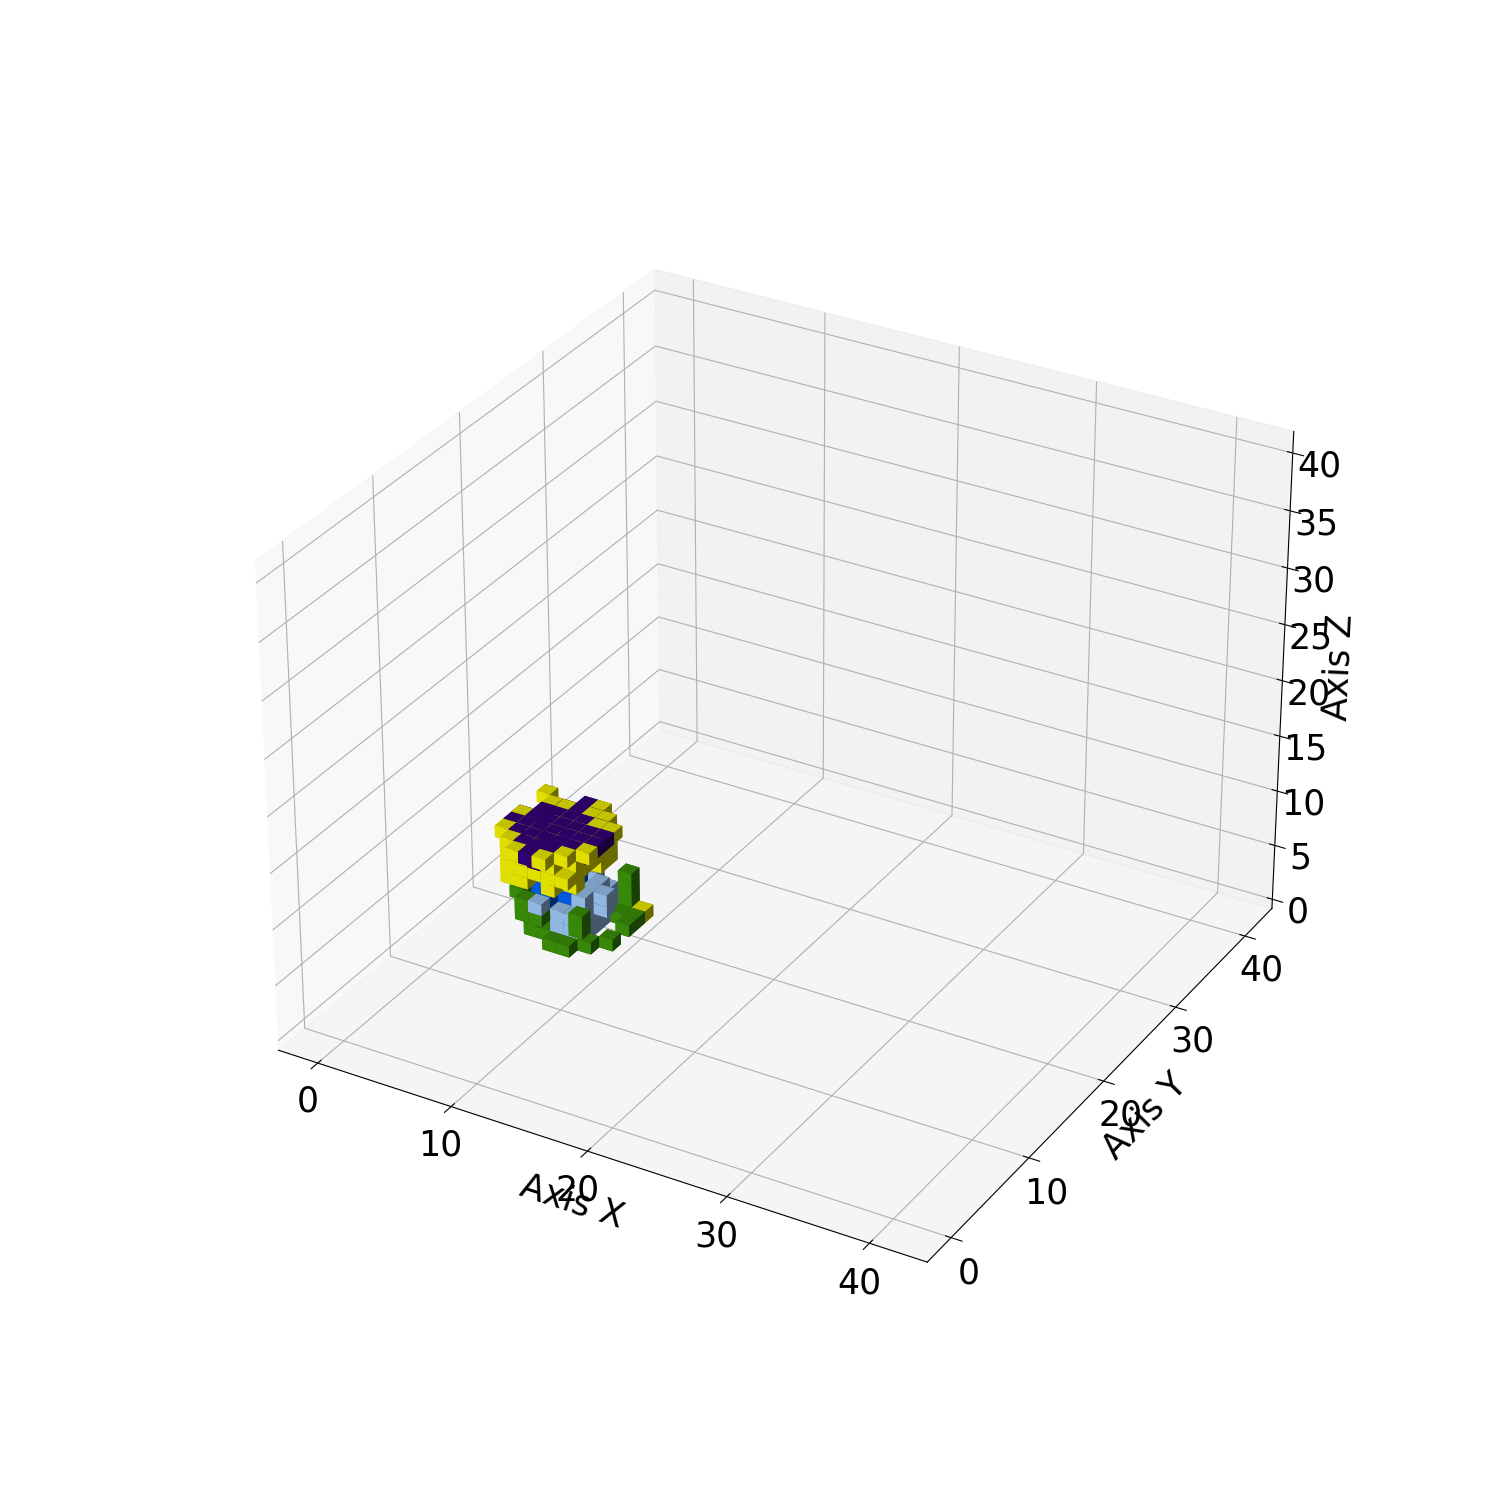

In [ ]:
plotGurobiOpenPitSolution(integratedVariableValues, integratedModel.openPitBlocks, integratedModel.openPitBlocksLengthLimits, integratedModel.openPitBlocksWidthLimits, integratedModel.openPitBlocksHeightLimits, integratedModel.openPitBlocksWidthLimits, integratedModel.openPitBlocksHeightLimits)

In [ ]:
plotintegratedModel(integratedModel.undergroundBlocksLenghtLimits, integratedModel.undergroundBlocksWidthLimits,integratedModel.undergroundBlocksHeightLimits, integratedModel.drawpoints_blocks, integratedModel.x_dt_values, integratedModel.y_dt_values, numberOfPeriods)

NameError: name 'plotintegratedModel' is not defined

In [ ]:
valoresBloques = [[],[],[],[],[]]
for indice,bloque in enumerate(integratedVariableValues):
    n_bloque = indice%11760
    if indice/11760 < 1:
        periodo = 0
        valoresBloques[periodo].append([n_bloque,bloque])
    elif  2 > (indice/11760) >= 1:
        periodo = 1
        valoresBloques[periodo].append([n_bloque,bloque])
    elif 3 > indice/11760 >= 2:
        periodo = 2
        valoresBloques[periodo].append([n_bloque,bloque])
    elif 4 >indice/11760 >= 3:
        periodo = 3
        valoresBloques[periodo].append([n_bloque,bloque])
    elif 5 > indice/11760 >= 4:
        periodo = 4
        valoresBloques[periodo].append([n_bloque,bloque])

In [ ]:
for periodo, bloques_periodo in enumerate(valoresBloques):
    for bloque in bloques_periodo:
        indice_bloque = bloque[0]
        proba = bloque[1]
        if proba > 0:
            proba_predecesores = []
            predecesores_activos = 0
            lista_proba_predecesor = []
            for predecesor in predecessorBlocks[indice_bloque]:
                suma = 0
                predecesores_activos += 1
                valores_proba_predecesor = []
                for s in range(0,periodo+1):
                    proba_predecesor = valoresBloques[s][predecesor][1]
                    lista_proba_predecesor.append(proba_predecesor)
                    valores_proba_predecesor.append(proba_predecesor)
                     
                    #    if proba_predecesor < proba:
                print(f'Bloque: {indice_bloque}, Proba: {proba},\nPredecesores: {predecessorBlocks[indice_bloque]},\nBloque predecesor, valores proba: {predecesor,valores_proba_predecesor}\nProba predecesor: {lista_proba_predecesor}, {periodo, s}')
                print()
            print()
            print()            
                    #suma += proba_predecesor
                    #proba_predecesores.append([predecesor,suma])
            #print(f'Bloque: {indice_bloque}, Proba: {proba}, Proba predecesores: {proba_predecesores}')

NameError: name 'predecessorBlocks' is not defined

Valores bloques = Lista de listas, son 5 listas, la lista 0 representa el periodo 0, cada sublista es de la forma, n_bloque y su prob de extracción.

In [ ]:
for b in self.integratedModel.openPitBlocks:
    for ti in self.integratedModel.t_C:
        #if ti == 0:
        #    print(f'Periodo: {ti}, Bloque: {b} ')
        #print("Periodo, bloque")
        for a in self.integratedModel.predecessorsBlocks[b]:
            for s in range(0,ti+1):
                if ti == 0:
                    if (valoresBloques[s][a] >= valoresBloques[ti][b]):
                        if valoresBloques[s][a][1]>0:
                            print(f'Periodo: {ti}, Bloque: {b} ')
                            print(f'Suma {valoresBloques[s][a]} >= {valoresBloques[ti][b]}' )
                            print()


Periodo: 0, Bloque: 291 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 318 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 319 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 319 
Suma [0, 0.004930381787317259] >= [0, 0.0]

Periodo: 0, Bloque: 320 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 346 
Suma [0, 0.004930381787317259] >= [0, 0.0]

Periodo: 0, Bloque: 347 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 347 
Suma [0, 0.004930381787317259] >= [0, 0.0]

Periodo: 0, Bloque: 348 
Suma [0, 0.004930381787317259] >= [0, 0.0]

Periodo: 0, Bloque: 375 
Suma [0, 0.004930381787317259] >= [0, 0.0]

Periodo: 0, Bloque: 1047 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 1074 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 1074 
Suma [0, 0.004878048780487805] >= [0, 0.0]

Periodo: 0, Bloque: 1075 
Suma [0, 0.004761904761904762] >= [0, 0.0]

Periodo: 0, Bloque: 1075 
Suma

In [ ]:
len(self.integratedModel.x_bt)/self.integratedModel.numberOfPeriods

11760.0

In [ ]:
self.integratedModel.predecessorsBlocks[0]

[784, 785, 812]

In [ ]:
predecessorBlocks = {}
for blocklist in self.integratedModel.predecessorBlock:
            print(blocklist)
            if blocklist[0] not in predecessorBlocks.keys():
                predecessorBlocks[blocklist[0]] = []
            if blocklist[0] != blocklist[1]:
                predecessorBlocks[blocklist[0]].append(blocklist[1])

[0, 784]
[0, 785]
[0, 812]
[1, 784]
[1, 785]
[1, 786]
[1, 813]
[2, 785]
[2, 786]
[2, 787]
[2, 814]
[3, 786]
[3, 787]
[3, 788]
[3, 815]
[4, 787]
[4, 788]
[4, 789]
[4, 816]
[5, 788]
[5, 789]
[5, 790]
[5, 817]
[6, 789]
[6, 790]
[6, 791]
[6, 818]
[7, 790]
[7, 791]
[7, 792]
[7, 819]
[8, 791]
[8, 792]
[8, 793]
[8, 820]
[9, 792]
[9, 793]
[9, 794]
[9, 821]
[10, 793]
[10, 794]
[10, 795]
[10, 822]
[11, 794]
[11, 795]
[11, 796]
[11, 823]
[12, 795]
[12, 796]
[12, 797]
[12, 824]
[13, 796]
[13, 797]
[13, 798]
[13, 825]
[14, 797]
[14, 798]
[14, 799]
[14, 826]
[15, 798]
[15, 799]
[15, 800]
[15, 827]
[16, 799]
[16, 800]
[16, 801]
[16, 828]
[17, 800]
[17, 801]
[17, 802]
[17, 829]
[18, 801]
[18, 802]
[18, 803]
[18, 830]
[19, 802]
[19, 803]
[19, 804]
[19, 831]
[20, 803]
[20, 804]
[20, 805]
[20, 832]
[21, 804]
[21, 805]
[21, 806]
[21, 833]
[22, 805]
[22, 806]
[22, 807]
[22, 834]
[23, 806]
[23, 807]
[23, 808]
[23, 835]
[24, 807]
[24, 808]
[24, 809]
[24, 836]
[25, 808]
[25, 809]
[25, 810]
[25, 837]
[26, 809]

In [ ]:
predecessorBlocks[11759]

[]

In [ ]:
import pandas
data={"integratedVariableValues": integratedVariableValues, "self.integratedModel.openPitBlocks": self.integratedModel.openPitBlocks, "self.integratedModel.openPitBlocksLengthLimits": self.integratedModel.openPitBlocksLengthLimits, "self.integratedModel.openPitBlocksWidthLimits":self.integratedModel.openPitBlocksWidthLimits, "self.integratedModel.openPitBlocksHeightLimits": self.integratedModel.openPitBlocksHeightLimits, "self.integratedModel.undergroundBlocksWidthLimits": self.integratedModel.undergroundBlocksWidthLimits, "self.integratedModel.undergroundBlocksHeightLimits": self.integratedModel.undergroundBlocksHeightLimits , "openPit_xbt_values": self.integratedModel.x_bt_values}
df = pandas.DataFrame.from_dict(data, orient='index')
df = df.transpose()
df.to_csv("integerSolution5PeriodsNo.csv", sep=',',index=False)